# ISLP - Chapter 10 - Exercise 8
### Author: pzuehlke

Let's start by importing the necessary libraries and checking if a GPU is available:

In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


We need to preprocess the images to match the requirements of the ResNet50 model.
More precisely, we:
1. Create a pipeline of transformations that will be applied to
   each image (the same ones as on p. $ 453 $).
2. Open the image and make sure it is in the RGB format.
3. Create a copy of the original image to display it later.
4. Apply the transformations to the image and add a batch dimension to the
   front, changing the tensor shape from $ (3, 224, 224) $ to $ (1, 3, 224, 224) $.

In [18]:
def preprocess_image(image_path):
    """ Preprocesses an individual image for input to the pretrained CNN. """
    # Get the preprocessing transforms specific to the model (p. 453):
    preprocess = transforms.Compose([
        # Resize shortest side to 256 pixelsa (different from the book but yields better results):
        transforms.Resize(256),
        transforms.CenterCrop(224),     # crop 224 x 224 square from the center
        transforms.ToTensor(),          # converts to a tensor
        # Normalize each channel:
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                             std=[0.229, 0.224, 0.225]),
    ])
    
    # Open and convert the image to RGB:
    img = Image.open(image_path).convert("RGB")
    original_img = img.copy()
    # Apply preprocessing transforms and add batch dimension:
    tensor = preprocess(img).unsqueeze(0)
    
    return tensor, original_img

We now instantiate the model as in the lab (p. $ 453 $, cells $ [62] $ and $
[63] $). Since it is already pretrained, we proceed directly to set it to
evaluation mode.

In [19]:
weights = ResNet50_Weights.DEFAULT
resnet_model = resnet50(weights=weights)
resnet_model.to(device)
resnet_model.eval()
# Extract human-readable labels ("dog", "cat", etc.) from the weights metadata:
index_to_label_dict = weights.meta["categories"]

Now we'll obtain the predictions and probabilities for each image and list the
top $ 5 $ predictions for each image. First we create a procedure to do this for
individual images:

In [20]:
def predict_image(image_tensor):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = resnet_model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
        
        # Get top 5 predictions for this image:
        top5_probs, top5_classes = torch.topk(probabilities, 5)
        
        # Convert class indices to labels:
        top5_labels = [index_to_label_dict[index.item()] for index in top5_classes]
        
    return top5_probs, top5_classes, top5_labels

Finally, we create a main procedure to process an entire directory of images and display the results:

In [ ]:
def classify_animal_images(image_directory):
    # Get image files:
    image_files = [file for file in os.listdir(image_directory) 
                  if file.lower().endswith((".png", ".jpg", ".jpeg"))]
    
    # Setup figure for plotting:
    image_files = image_files[:10]  # process at most 10 images as in the statement
    fig_count = min(len(image_files), 10)
    fig, axes = plt.subplots(fig_count, 2, figsize=(14, 5 * fig_count))
    
    # Process each image:
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_directory, image_file)
        image_tensor, original_img = preprocess_image(image_path)

        # Make prediction:
        top5_probs, top5_classes, top5_labels = predict_image(image_tensor)
        
        # Display image:
        ax_img, ax_bar = axes[i, 0], axes[i, 1]
        ax_img.imshow(original_img)
        ax_img.set_title(f"Image: {image_file}")
        ax_img.axis("off")
        # Display top 5 predictions as a bar chart:
        top5_probs_np = top5_probs.cpu().numpy() * 100  # Convert probs to percentage
        y_positions = np.arange(5)
        ax_bar.barh(y_positions, top5_probs_np)  # horizontal bar chart
        ax_bar.set_yticks(y_positions)
        ax_bar.set_yticklabels(top5_labels)
        ax_bar.set_xlabel("probability (%)")
        ax_bar.set_title("Top 5 Predictions")
        
    plt.tight_layout()
    plt.show()

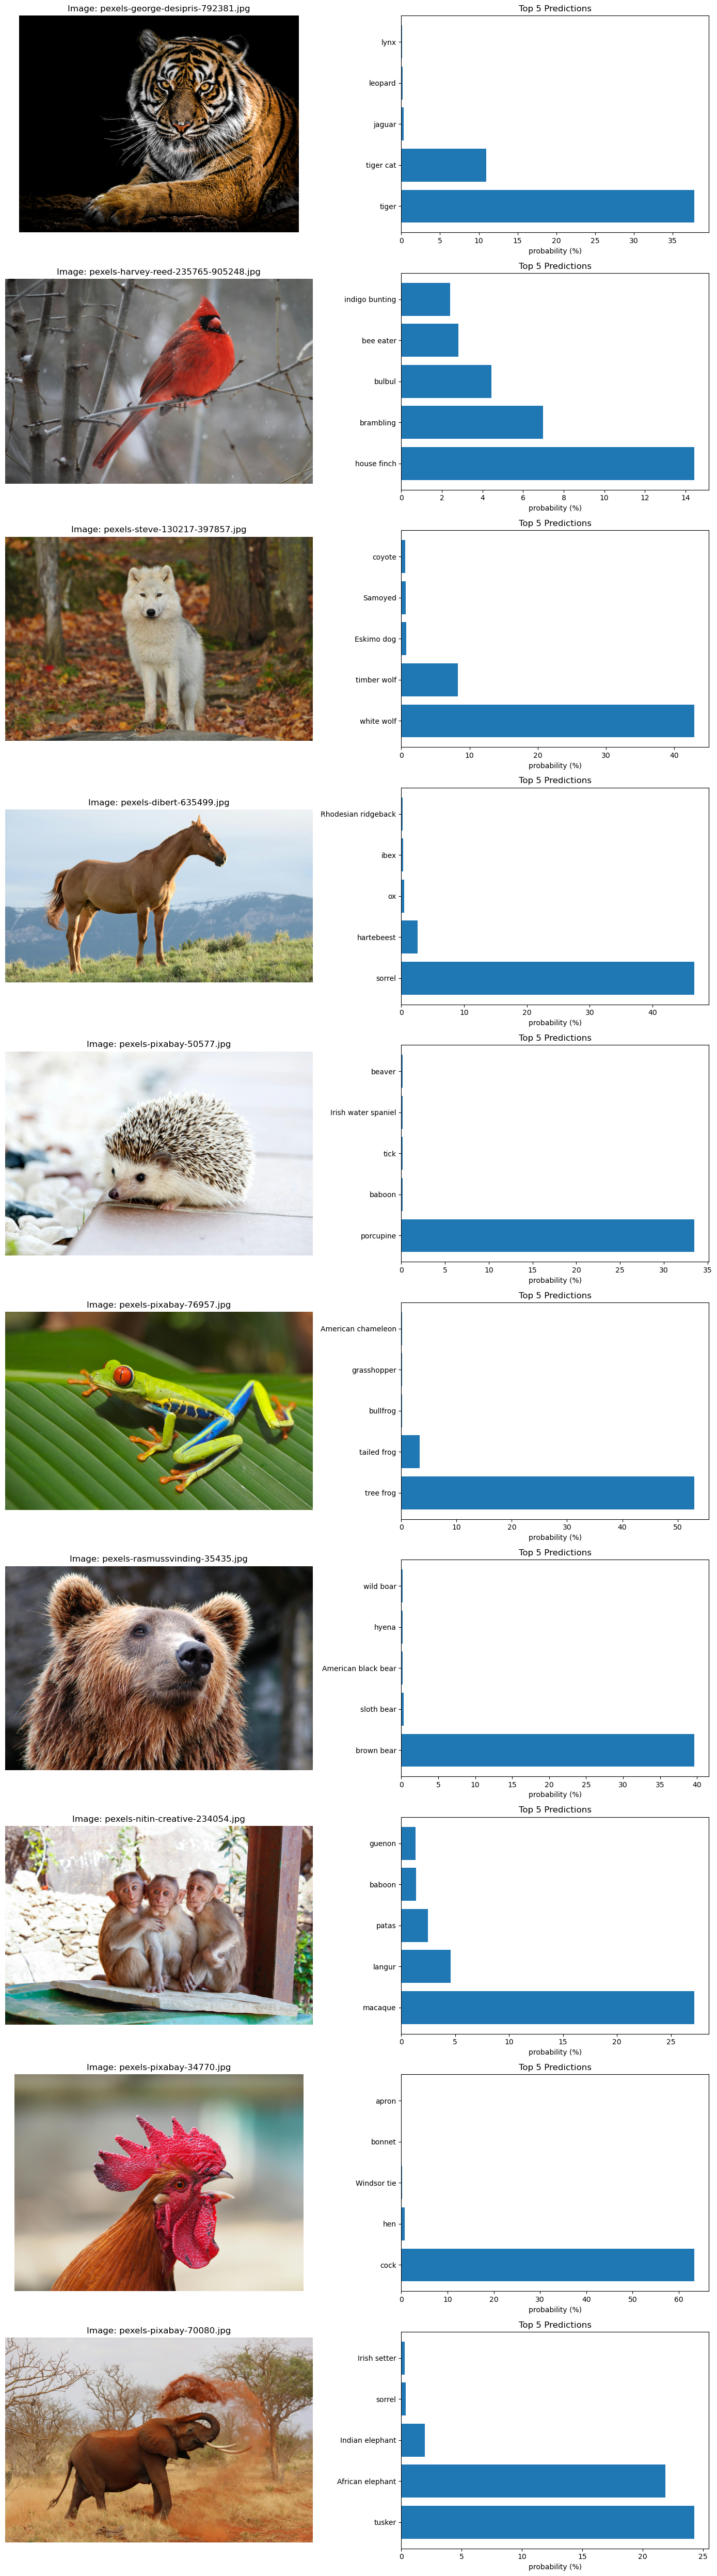

In [22]:
directory = "images"
classify_animal_images(directory)

For this set of images, apparently the only misclassified ones were:
* The cardinal (picture $ \# 2 $), which the model thought was a house finch;
* The African elephant (last picture), which was misclassified as a tusker elephant.

In [ ]:
del resnet_model
if torch.cuda.is_available():
    torch.cuda.empty_cache()